In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf


import pandas as pd
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from google.colab import files

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
import datetime
%load_ext tensorboard

In [3]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def make_predictions_and_save(model, file_name):
    probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
    output = np.argmax(probability_model.predict(X_test), axis=1)
    prediction_df = pd.DataFrame(list(range(1, len(X_test) + 1)))
    prediction_df.columns = ['ImageId']
    prediction_df['Label'] = pd.DataFrame(output)
    prediction_df.to_csv('predictions/' + file_name + '.csv', index=False)

In [ ]:
# !mkdir -p ~/.kaggle

# from google.colab import files
# files.upload()

In [5]:
!mkdir predictions

In [6]:
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle competitions download -c digit-recognizer

 82% 5.00M/6.09M [00:00<00:00, 13.9MB/s]
100% 6.09M/6.09M [00:00<00:00, 15.4MB/s]
  0% 0.00/9.16M [00:00<?, ?B/s]
100% 9.16M/9.16M [00:00<00:00, 84.5MB/s]
  0% 0.00/235k [00:00<?, ?B/s]
100% 235k/235k [00:00<00:00, 78.5MB/s]


In [8]:
TRAIN_DATA_PATH = "train.csv.zip"
TEST_DATA_PATH = "test.csv.zip"

In [9]:
#Load Data
train = pd.read_csv(TRAIN_DATA_PATH, compression='zip', header=0, sep=',', quotechar='"')
test = pd.read_csv(TEST_DATA_PATH, compression='zip', header=0, sep=',', quotechar='"')

In [10]:
Y_train = train["label"]
X_train = train.drop(labels=["label"], axis=1)
del(train)
X_test = test

### Normalization

In [11]:
X_train = X_train / 255.0

In [12]:
X_test = X_test / 255.0

In [13]:
Y_train = tf.keras.utils.to_categorical(Y_train, num_classes=10)

### Reshape Pixels

In [14]:
X_train = X_train.values.reshape(-1, 28, 28, 1)
X_test = X_test.values.reshape(-1, 28, 28, 1)

### Split training and validation sets

In [15]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=2)

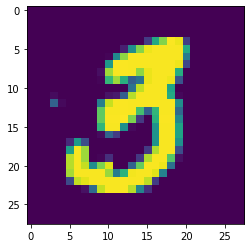

In [16]:
plt.imshow(X_train[1000][:,:,0])

# MODEL

### Experimenting with feature maps

In [ ]:
L1_dims = [8, 16, 24, 32, 48, 64]
model = [0]*6
# Define and compile all models
for i in range(6):
  model[i] = Sequential()
  model[i].add(Conv2D(L1_dims[i], 5, padding='same', activation='relu', input_shape=(28, 28, 1)))
  model[i].add(MaxPooling2D())
  model[i].add(Conv2D(L1_dims[i]*2, 5, padding='same', activation='relu', input_shape=(28, 28, 1)))
  model[i].add(MaxPooling2D())
  model[i].add(Flatten())
  model[i].add(Dense(256, activation='relu'))
  model[i].add(Dense(10, activation='softmax'))
  model[i].compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


# Train
for i in range(6):
  model[i].fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=20, verbose=0)
  train_accuracy = round(model[i].evaluate(X_train, Y_train, verbose=0)[1], 4)
  val_accuracy = round(model[i].evaluate(X_val, Y_val, verbose=0)[1], 4)
  print(f"CNN {L1_dims[i]}: Train Accuracy: {train_accuracy}, Val Accuracy: {val_accuracy}")


CNN 8: Train Accuracy: 0.9987830519676208, Val Accuracy: 0.9869047403335571
CNN 16: Train Accuracy: 0.9988889098167419, Val Accuracy: 0.9897618889808655
CNN 24: Train Accuracy: 0.9926190376281738, Val Accuracy: 0.9821428656578064
CNN 32: Train Accuracy: 0.99957674741745, Val Accuracy: 0.9919047355651855
CNN 48: Train Accuracy: 0.9992856979370117, Val Accuracy: 0.9909523725509644
CNN 64: Train Accuracy: 0.9992063641548157, Val Accuracy: 0.9926190376281738


In [ ]:
# Considering CNN 32 better
make_predictions_and_save(model[3], 'model_3_3')
files.download('predictions/model_3_3.csv')

### Experimenting with size of dense layers

In [17]:
model = [0]*7
# Define and compile all models
for i in range(7):
  model[i] = Sequential()
  model[i].add(Conv2D(32, 5, padding='same', activation='relu', input_shape=(28, 28, 1)))
  model[i].add(MaxPooling2D())
  model[i].add(Conv2D(64, 5, padding='same', activation='relu', input_shape=(28, 28, 1)))
  model[i].add(MaxPooling2D())
  model[i].add(Flatten())
  model[i].add(Dense(2**(i+5), activation='relu'))
  model[i].add(Dense(10, activation='softmax'))
  model[i].compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


# Train
for i in range(7):
  model[i].fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=30, verbose=0)
  train_accuracy = round(model[i].evaluate(X_train, Y_train, verbose=0)[1], 4)
  val_accuracy = round(model[i].evaluate(X_val, Y_val, verbose=0)[1], 4)
  print(f"D {2**(i+5)} : Train Accuracy: {train_accuracy}, Val Accuracy: {val_accuracy}")


D 32 : Train Accuracy: 0.9992, Val Accuracy: 0.9914
D 64 : Train Accuracy: 0.9977, Val Accuracy: 0.9881
D 128 : Train Accuracy: 0.9983, Val Accuracy: 0.9881
D 256 : Train Accuracy: 0.999, Val Accuracy: 0.9905
D 512 : Train Accuracy: 0.9997, Val Accuracy: 0.9917
D 1024 : Train Accuracy: 0.9998, Val Accuracy: 0.9917
D 2048 : Train Accuracy: 0.9997, Val Accuracy: 0.9902


In [ ]:
# Considering 128 dense units better
make_predictions_and_save(model[2], 'model_4_5')
files.download('predictions/model_4_5.csv')

### Experimenting with dropout

In [ ]:
model = [0]*8
# Define and compile all models
for i in range(8):
  model[i] = Sequential()
  model[i].add(Conv2D(32, 5, padding='same', activation='relu', input_shape=(28, 28, 1)))
  model[i].add(MaxPooling2D())
  model[i].add(Dropout(i*0.1))
  model[i].add(Conv2D(64, 5, padding='same', activation='relu', input_shape=(28, 28, 1)))
  model[i].add(MaxPooling2D())
  model[i].add(Dropout(i*0.1))
  model[i].add(Flatten())
  model[i].add(Dense(256, activation='relu'))
  model[i].add(Dropout(i*0.1))
  model[i].add(Dense(10, activation='softmax'))
  model[i].compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


# Train
for i in range(8):
  model[i].fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=30, verbose=0)
  train_accuracy = round(model[i].evaluate(X_train, Y_train, verbose=0)[1], 4)
  val_accuracy = round(model[i].evaluate(X_val, Y_val, verbose=0)[1], 4)
  print(f"Droupout {i * 0.1} : Train Accuracy: {train_accuracy}, Val Accuracy: {val_accuracy}")


Droupout 0.0 : Train Accuracy: 0.999, Val Accuracy: 0.989
Droupout 0.1 : Train Accuracy: 0.9992, Val Accuracy: 0.9921
Droupout 0.2 : Train Accuracy: 0.9985, Val Accuracy: 0.989
Droupout 0.30000000000000004 : Train Accuracy: 0.9992, Val Accuracy: 0.991
Droupout 0.4 : Train Accuracy: 0.9994, Val Accuracy: 0.9933
Droupout 0.5 : Train Accuracy: 0.9983, Val Accuracy: 0.9924
Droupout 0.6000000000000001 : Train Accuracy: 0.9964, Val Accuracy: 0.9924
Droupout 0.7000000000000001 : Train Accuracy: 0.9917, Val Accuracy: 0.9874


In [ ]:
# Going with 0.4 dropout

### Adding data augmentation, optimizer and learning rate annealer

In [ ]:
optimizer = tf.keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=10,
        zoom_range = 0.1,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=False,
        vertical_flip=False)


datagen.fit(X_train)

learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)



In [ ]:
# [32C5-P2-0.4d]-[64C5-P2-0.4d]-F-256D-0.4d-10D

model = Sequential()
model.add(Conv2D(32, 5, padding='same', activation='relu', input_shape=(28, 28, 1)))
model.add(MaxPooling2D())
model.add(Dropout(0.4))
model.add(Conv2D(64, 5, padding='same', activation='relu', input_shape=(28, 28, 1)))
model.add(MaxPooling2D())
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(10, activation='softmax'))
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
Model = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=100),
                            validation_data=(X_val, Y_val, ), epochs=20, 
                            steps_per_epoch=X_train.shape[0]/100,
                            verbose=1, callbacks=[learning_rate_reduction])

Epoch 1/20
378/378 [==============================] - 13s 34ms/step - loss: 0.4728 - accuracy: 0.8458 - val_loss: 0.0766 - val_accuracy: 0.9776 - lr: 0.0010
Epoch 2/20
378/378 [==============================] - 13s 34ms/step - loss: 0.1603 - accuracy: 0.9511 - val_loss: 0.0570 - val_accuracy: 0.9821 - lr: 0.0010
Epoch 3/20
378/378 [==============================] - 13s 35ms/step - loss: 0.1233 - accuracy: 0.9624 - val_loss: 0.0443 - val_accuracy: 0.9874 - lr: 0.0010
Epoch 4/20
378/378 [==============================] - 13s 33ms/step - loss: 0.1051 - accuracy: 0.9687 - val_loss: 0.0360 - val_accuracy: 0.9902 - lr: 0.0010
Epoch 5/20
378/378 [==============================] - 13s 34ms/step - loss: 0.0940 - accuracy: 0.9714 - val_loss: 0.0345 - val_accuracy: 0.9902 - lr: 0.0010
Epoch 6/20
378/378 [==============================] - 13s 34ms/step - loss: 0.0872 - accuracy: 0.9734 - val_loss: 0.0348 - val_accuracy: 0.9900 - lr: 0.0010
Epoch 7/20
378/378 [==============================] - 13s 

In [ ]:
 make_predictions_and_save(model, 'model_5_2')
files.download('predictions/model_5_2.csv')

5x5 CNN -> [3x3]*2, 
maxpool subsampling -> CNN with stride 2, which is learnable, 
Batch Normalization

In [ ]:
# Latest Model
# [32C3-BN]*2-[32C5S2-BN]-0.4d-[64C3-BN]*2-[64C5S2-BN]-0.4d-F-256D-10D 20E

model = Sequential()
model.add(Conv2D(32, 3, padding='same', activation='relu', input_shape=(28, 28, 1)))
model.add(tf.keras.layers.BatchNormalization())
model.add(Conv2D(32, 3, padding='same', activation='relu', input_shape=(28, 28, 1)))
model.add(tf.keras.layers.BatchNormalization())
model.add(Conv2D(32, 5, padding='same',strides=2, activation='relu', input_shape=(28, 28, 1)))
model.add(tf.keras.layers.BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(64, 3, padding='same', activation='relu', input_shape=(28, 28, 1)))
model.add(tf.keras.layers.BatchNormalization())
model.add(Conv2D(64, 3, padding='same', activation='relu', input_shape=(28, 28, 1)))
model.add(tf.keras.layers.BatchNormalization())
model.add(Conv2D(64, 5, padding='same',strides=2, activation='relu', input_shape=(28, 28, 1)))
model.add(tf.keras.layers.BatchNormalization())
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(10, activation='softmax'))
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
Model = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=100),
                            validation_data=(X_val, Y_val, ), epochs=20, 
                            steps_per_epoch=X_train.shape[0]/100,
                            verbose=1, callbacks=[learning_rate_reduction])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
378/378 [==============================] - 12s 31ms/step - loss: 0.4417 - accuracy: 0.8684 - val_loss: 20.1690 - val_accuracy: 0.1757 - lr: 0.0010
Epoch 2/20
378/378 [==============================] - 12s 31ms/step - loss: 0.1642 - accuracy: 0.9559 - val_loss: 0.0968 - val_accuracy: 0.9829 - lr: 0.0010
Epoch 3/20
378/378 [==============================] - 11s 30ms/step - loss: 0.1313 - accuracy: 0.9667 - val_loss: 0.0926 - val_accuracy: 0.9805 - lr: 0.0010
Epoch 4/20
378/378 [==============================] - 12s 31ms/step - loss: 0.1168 - accuracy: 0.9703 - val_loss: 0.0557 - val_accuracy: 0.9883 - lr: 0.0010
Epoch 5/20
378/378 [==============================] - 11s 30ms/step - loss: 0.1057 - accuracy: 0.9747 - val_loss: 0.0512 - val_accuracy: 0.9848 - lr: 0.0010
Epoch 6/20
378/378 [==============================] - 12s 31ms/step - loss: 0.0965 - accuracy: 0.9768 - val_loss: 0.0564 - val_accuracy: 0

In [ ]:
 make_predictions_and_save(model, 'model_6_1')
files.download('predictions/model_6_1.csv')

## Download the weights

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# create on Colab directory
model.save_weights('model_weights.h5')    
model_file = drive.CreateFile({'title' : 'model_weights.h5'})
model_file.SetContentFile('model_weights.h5')
model_file.Upload()

# download to google drive
drive.CreateFile({'id': model_file.get('id')})